# Binary Classifier (blank vs hog)

## Libraries and rough analysis

Importing necessary Libraries

In [ ]:
import os
import sys
from collections import Counter

import cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import torchvision
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchvision import datasets, transforms

torch.backends.cudnn.deterministic = True

In [ ]:
# printing the versions of packages that helps us in future debugging

print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("CV2 version : ", cv2.__version__)
print("matplotlib version : ", matplotlib.__version__)
print("numpy version : ", np.__version__)
print("torch version : ", torch.__version__)
print("torchinfo version : ", torchinfo.__version__)
print("torchvision version : ", torchvision.__version__)
print("PIL version : ", PIL.__version__)
print("scikit-learn version: ", sklearn.__version__)


Platform: win32
Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
---
CV2 version :  4.11.0
matplotlib version :  3.10.1
numpy version :  2.2.4
torch version :  2.6.0+cu118
torchinfo version :  1.8.0
torchvision version :  0.21.0+cpu
PIL version :  11.2.1
scikit-learn version:  1.6.1
tqdm version:  4.67.1


In [ ]:
# checking whether the cuda is available or not

torch.cuda.is_available()

True

In [6]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA")

PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
Device name: NVIDIA GeForce RTX 2050


In [ ]:
# saving he cuda class in device var

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using {device} device.")

Using cuda device.


In [ ]:
# arranging the data in train and test directories

data_dir = "."
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

print("Train directory:", train_dir)
print("Test directory:", test_dir)

Train directory: .\train
Test directory: .\test


In [9]:
os.listdir(train_dir)

['blank', 'hog']

In [10]:
# number of images in classes

print('length of blanks: ', len(os.listdir(os.path.join(train_dir, 'blank'))))
print('length of circles: ', len(os.listdir(os.path.join(train_dir, 'hog'))))

length of blanks:  2213
length of circles:  978


In [14]:
# let's see the images in the directory

blank_images = os.listdir(os.path.join(train_dir, 'blank'))
one_blank_image = blank_images[0]

In [15]:
one_blank_image

'ZJ000013.jpg'

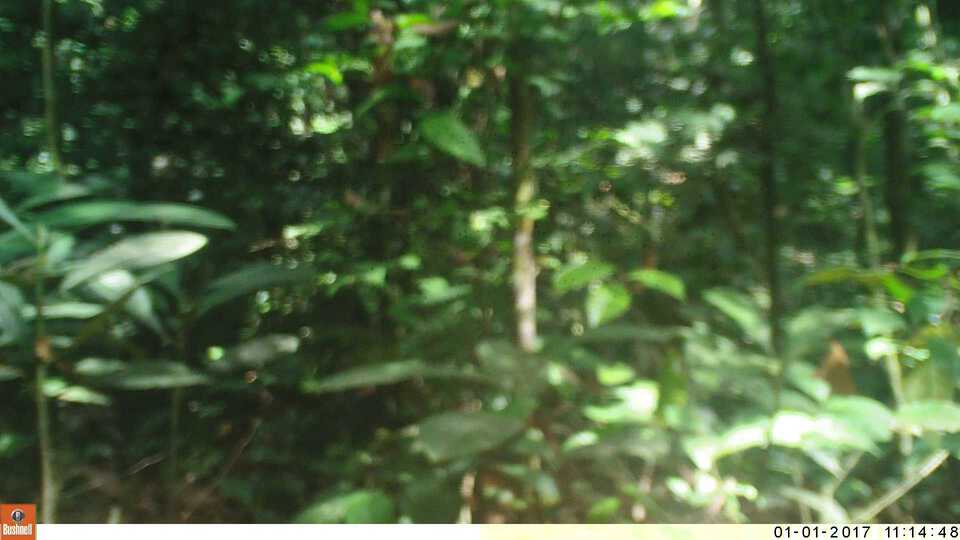

In [17]:
blank_image_path = os.path.join(train_dir, 'blank', one_blank_image)
blank_image = Image.open(blank_image_path)
blank_image

In [18]:
blank_image._mode

'RGB'

In [19]:
blank_image.size

(960, 540)

In [28]:
hog_images = os.listdir(os.path.join(train_dir, 'hog'))
one_hog_image = hog_images[100]
hog_image_path = os.path.join(train_dir, 'hog', one_hog_image)
hog_image = Image.open(hog_image_path)

In [29]:
print(hog_image._mode)
print(hog_image.size)

RGB
(960, 540)


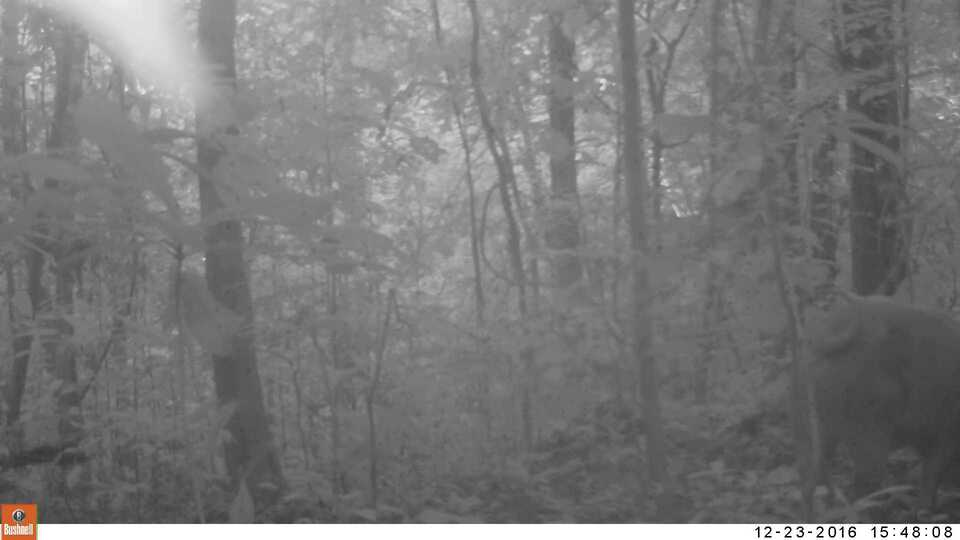

In [30]:
hog_image

## Preparing Data for model

In [31]:
# first converting every images into standard 

class ConvertToRGB:
    def __call__(self, image):
        if image.mode != "RGB":
            image = image.convert("RGB")
        return image

In [32]:
# transform every images into 224*224, also convert them into tensor

transform = transforms.Compose([
    ConvertToRGB(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [35]:
os.listdir(train_dir)

['blank', 'hog']

In [36]:
# laoding data set using ImageFolder

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [37]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 3191
    Root location: .\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [42]:
train_dataset.classes

['blank', 'hog']

In [43]:
im = train_dataset.imgs
im[0]

('.\\train\\blank\\ZJ000013.jpg', 0)

In [44]:
{x[1] for x in im}

{0, 1}

In [48]:
# splitting the dataset into train and test

training_dataset, testing_dataset = random_split(train_dataset, [0.8, 0.2])

In [49]:
len(training_dataset)

2553

In [ ]:
# count the number of calsses

Counter([x[1] for x in training_dataset])

Counter({0: 1768, 1: 785})

it means out training_dataset has 1768 blank images and 785 hog images

In [58]:
# count the number of classes in testing dataset
Counter([x[1] for x in testing_dataset])

Counter({0: 445, 1: 193})

In [59]:
# before loading the transformed dataset into model , we need to create the DataLoader of these dataset

batch_size = 32
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)

In [61]:
len(train_loader.dataset), len(test_loader.dataset)

(2553, 638)

In [ ]:
# shapes of the images and labels

img, label = next(iter(train_loader))
img.shape, label.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [66]:
print(label)
print("the total numbers of label:",len(label))

tensor([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0])
the total numbers of label: 32


## Building Shallow Neural Network

In [69]:
# normalfuly connected nn, which has input layer, two hidden layers and output layer

# flattening the image after transforming it into tensor, before passing it to the model

tensor_flatten = nn.Flatten()(img)
tensor_flatten.shape

torch.Size([32, 150528])

In [71]:
height = 224
width = 224

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3 * height * width, 512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
)

print(type(model))
print(model)

<class 'torch.nn.modules.container.Sequential'>
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)


In [72]:
summary(model, input_size=(32, 3, height, width))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 2]                   --
├─Flatten: 1-1                           [32, 150528]              --
├─Linear: 1-2                            [32, 512]                 77,070,848
├─ReLU: 1-3                              [32, 512]                 --
├─Linear: 1-4                            [32, 128]                 65,664
├─ReLU: 1-5                              [32, 128]                 --
├─Linear: 1-6                            [32, 2]                   258
Total params: 77,136,770
Trainable params: 77,136,770
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 2.47
Input size (MB): 19.27
Forward/backward pass size (MB): 0.16
Params size (MB): 308.55
Estimated Total Size (MB): 327.98

what is ReLU?

activation function which simply means neglect the negative value and treat it as 0

## Training The Model

Cross-Entropy Loss is a commonly used loss function for classification tasks, including binary and multi-class classification. It measures the difference between the predicted probability distribution (output of the model) and the true distribution (actual labels).

Formula for Cross-Entropy Loss:
For a single data point in binary classification:

L = -[y \cdot \log(p) + (1 - y) \cdot \log(1 - p)]

Where:

y is the true label (0 or 1).
p is the predicted probability for the positive class.

Why Use Cross-Entropy Loss?

- It penalizes incorrect predictions more heavily when the model is confident but wrong.
- It works well with probabilistic outputs, such as those produced by a softmax activation function in multi-class classification.

In [74]:
loss_fn = nn.CrossEntropyLoss()

Adam (short for Adaptive Moment Estimation) is a popular optimizer in deep learning. It combines the advantages of two other optimizers, AdaGrad and RMSProp, and is widely used due to its efficiency and ability to handle sparse gradients.

Key Features of Adam:
- Adaptive Learning Rates: Adam adjusts the learning rate for each parameter individually based on the first and second moments of the gradients.
- Momentum: It incorporates momentum to accelerate convergence and smooth updates.
- Efficient: Works well with large datasets and high-dimensional parameter spaces.

In [79]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_epochs(model, optimizer, loss_fn, data_loader, device = 'cpu'):

    training_loss = 0.0
    model.train()

    for inputs, targets in data_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        training_loss += loss.item() * inputs.size(0)

    return training_loss / len(data_loader.dataset)

In [162]:
# starting to train the model for 1 epoch

for epoch in range(50):
    train_loss = train_epochs(model, optimizer, loss_fn, train_loader, device)
    print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}")

Epoch 1, Training Loss: 0.1199
Epoch 2, Training Loss: 0.1186
Epoch 3, Training Loss: 0.1109
Epoch 4, Training Loss: 0.1044
Epoch 5, Training Loss: 0.1409
Epoch 6, Training Loss: 0.0971
Epoch 7, Training Loss: 0.0919
Epoch 8, Training Loss: 0.1166
Epoch 9, Training Loss: 0.1507
Epoch 10, Training Loss: 0.1224
Epoch 11, Training Loss: 0.1055
Epoch 12, Training Loss: 0.1240
Epoch 13, Training Loss: 0.1193
Epoch 14, Training Loss: 0.0986
Epoch 15, Training Loss: 0.0893
Epoch 16, Training Loss: 0.1608
Epoch 17, Training Loss: 0.1658
Epoch 18, Training Loss: 0.1503
Epoch 19, Training Loss: 0.1525
Epoch 20, Training Loss: 0.1489
Epoch 21, Training Loss: 0.0861
Epoch 22, Training Loss: 0.1318
Epoch 23, Training Loss: 0.1659
Epoch 24, Training Loss: 0.0820
Epoch 25, Training Loss: 0.0976
Epoch 26, Training Loss: 0.1096
Epoch 27, Training Loss: 0.0897
Epoch 28, Training Loss: 0.0815
Epoch 29, Training Loss: 0.1619
Epoch 30, Training Loss: 0.0951
Epoch 31, Training Loss: 0.0909
Epoch 32, Trainin

In [111]:
# predict function usinf softmax

def predict(model, data_loader, device = 'cpu'):
    all_probs = torch.tensor([]).to(device)
    model.eval()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            all_probs = torch.cat((all_probs, probs), dim=0)
    return all_probs

In [163]:
train_predicts = torch.argmax(predict(model, train_loader, device), dim=1)

In [165]:
targets_train = torch.cat([labels for _, labels in train_loader]).to(device)
is_correct_train = torch.eq(train_predicts, targets_train)
total_correct_train = torch.sum(is_correct_train).item()
accuracy_train = total_correct_train / len(train_loader.dataset)

print(f"Accuracy on the training data: {accuracy_train}")

Accuracy on the training data: 0.564042303172738


In [166]:
val_predicts = torch.argmax(predict(model, test_loader, device), dim=1)

In [167]:
targets_val = torch.cat([labels for _, labels in test_loader]).to(device)
is_correct_val = torch.eq(val_predicts, targets_val)
total_correct_val = torch.sum(is_correct_val).item()
accuracy_val = total_correct_val / len(test_loader.dataset)

print(f"Accuracy on the validation data: {accuracy_val}")

Accuracy on the validation data: 0.9529780564263323


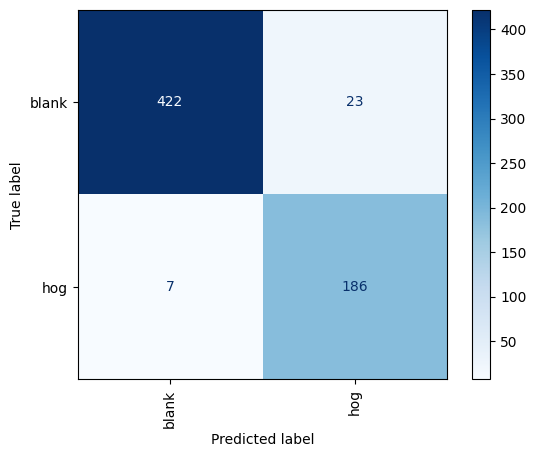

In [168]:
cm = confusion_matrix(targets_val.cpu(), val_predicts.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["blank", "hog"])

disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical");

## testing in Image 

In [137]:
img_path = os.path.join(test_dir, os.listdir(test_dir)[8])
img_path

'.\\test\\ZJ016495.jpg'

In [138]:
img = Image.open(img_path)

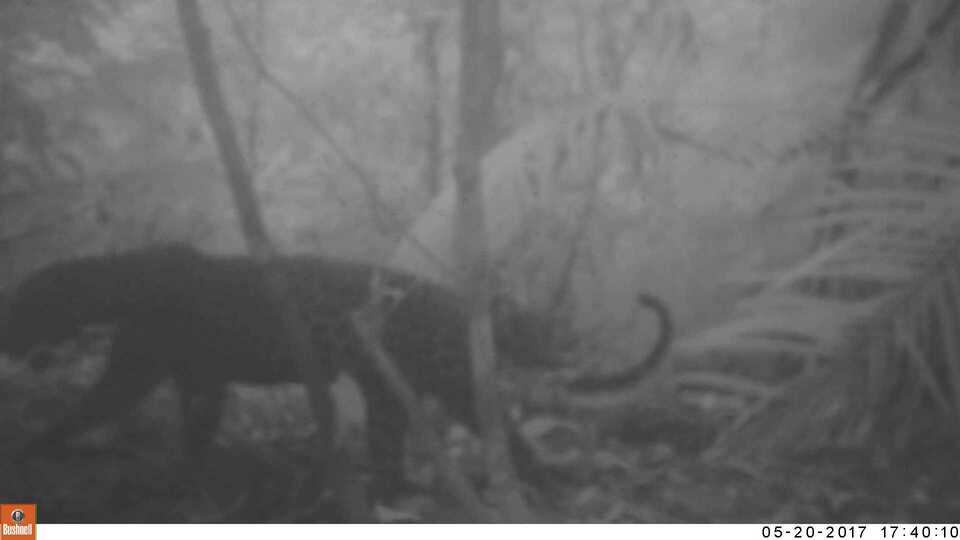

In [139]:
img

In [140]:
img = transform(img).unsqueeze(0).to(device)
img.shape

torch.Size([1, 3, 224, 224])

In [169]:
model.eval()
predicted = torch.argmax(model(img), dim=1)
predicted

tensor([0], device='cuda:0')

## saving the nn model


In [170]:
torch.save(model, os.path.join("trained_model", "shallownet"))

In [171]:
loaded_model = torch.load(os.path.join("trained_model", "shallownet"), weights_only=False)

In [172]:
loaded_model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=150528, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=2, bias=True)
)

In [173]:
img.shape

torch.Size([1, 3, 224, 224])

In [176]:
loaded_model.eval()
predicted = torch.argmax(loaded_model(img), dim=1)
predicted.item()

0

In [178]:
hog_img = Image.open(hog_image_path)

In [179]:
predicted = torch.argmax(loaded_model(transform(hog_img).unsqueeze(0).to(device)), dim=1)

In [180]:
predicted

tensor([1], device='cuda:0')

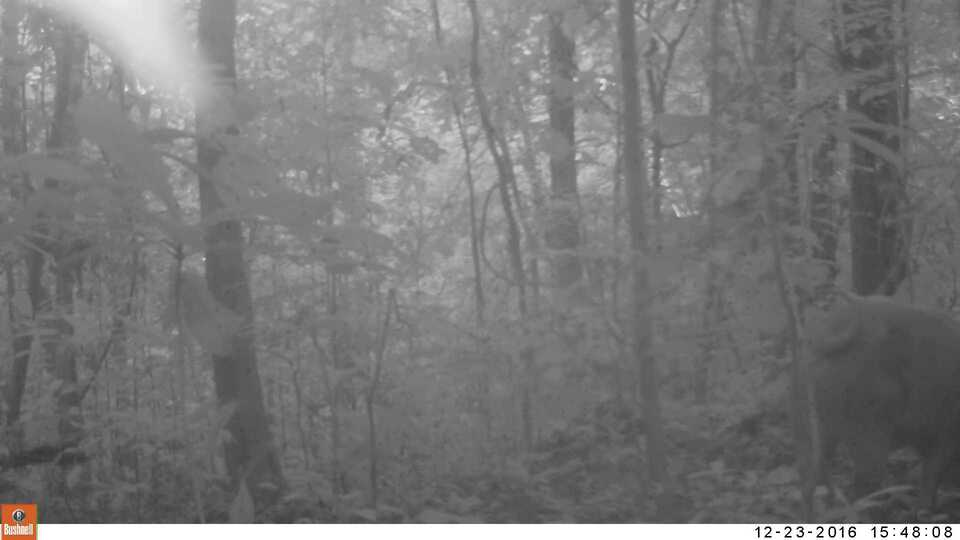

In [181]:
hog_img